# **COFFEE LEAF DISEASE IMAGE CLASSIFICATION**
Collaborators:
- Crystal Wanjiru
- Randell Mwania
- Victorine Imbuhila
- Sadi Kiri
- Ian Kedeyie
- Simon Ng'ethe

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Overview**
## **Business Understanding**
The project aims to address the significant threat posed by three major diseases—Coffee rust, Cercospora, and Phoma—to coffee plants in the highland areas of Kenya. These diseases have the potential to adversely impact the livelihoods of small-scale farmers who heavily depend on coffee cultivation. By implementing a technological solution for early and accurate detection of these diseases, the project seeks to empower farmers to take timely preventive measures, such as the application of fungicides, to mitigate the impact on their crops. The ultimate goal is to preserve the cultural and economic significance of coffee cultivation and contribute to the sustainability of Arabica coffee farming in the region.

## **Problem Statement**
The highland areas of Kenya, characterised by a rich tradition of coffee cultivation, face a critical challenge with the prevalence of three major diseases—coffee rust, cercospora, and phoma. These diseases severely threaten the coffee plants, endangering the livelihoods of small-scale farmers who rely heavily on coffee cultivation. The lack of early and accurate detection methods hampers farmers' ability to implement timely preventive measures, leading to significant crop losses. The absence of a technological solution increases the vulnerability of the coffee industry in the region, putting at risk not only the economic well-being of farmers but also the cultural heritage associated with coffee production.

## **Objectives**
##### **Main Objective:**
To develop a Convolutional Neural Network(CNN) based image classifcation model capable of accurarely distingushing between the three classes of Coffee leaf diseases.

##### Specific Objectives:
- To identify any patterns or anomalies in the data that may influence model performance.
- To train the model using the provided dataset and evaluate its perfomance on a separate validation set.
- To deploy the trained model making it accessible for stakeholders.

# **Data Understanding**
The dataset contains leaf images which were collected from Arabica coffee type and it shows three sets of Phoma, Rust and Cescospora images and one set of healthy images. The data was obtained from [Dataset on Mendeley](https://data.mendeley.com/datasets/t2r6rszp5c/1), [Dataset on Mendeley](https://data.mendeley.com/datasets/tgv3zb82nd/1) and web scrapping with the 'Download All images' extension from the chrome web store.



In [2]:
# Import necessary libraries
import imghdr
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2

# Import the necessary layers and models from TensorFlow Keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model


In [3]:
# Specify the path to the main folder containing subfolders for each class
main_folder_path = '/content/drive/MyDrive/Imageclassification3/Data'

# Get a list of subfolders (each subfolder corresponds to a class)
class_folders = [folder for folder in os.listdir(main_folder_path) if os.path.isdir(os.path.join(main_folder_path, folder))and folder != ".ipynb_checkpoints"]

# Display the number of classes
num_classes = len(class_folders)
print(f"Number of Classes: {num_classes}")

# Display the number of images in each class
for class_name in class_folders:
    class_path = os.path.join(main_folder_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class: {class_name}, Number of Images: {num_images}")


Number of Classes: 4
Class: Phoma, Number of Images: 6571
Class: Healthy, Number of Images: 8587
Class: Cerscospora, Number of Images: 6200
Class: Leafrust, Number of Images: 8315


The data contains 29,673 images from four different classes. One set contains 8587 images of healthy coffee leaves while the other 3 contain 6571 images of Phoma, 6200 images of Cercospora and 8315 images of Leafrust.

# **Data Preparation**
The data pre-processing involved noise filtering and contrast stretching. To ensure uniformity, non-square images were cropped to obtain central square portions. To mitigate overfitting and enhance smaller datasets, data augmentation techniques such as rotation and flipping were applied, expanding the collected field images into larger datasets.

In [ ]:
# Define the main folder path
main_folder_path = '/content/drive/MyDrive/Imageclassification3/Data'

# Specify the acceptable image extensions
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

# Iterate through each image class in the main folder
for image_class in os.listdir(main_folder_path):

    # Iterate through each image in the current image class
    for image in os.listdir(os.path.join(main_folder_path, image_class)):

        # Construct the full image path
        image_path = os.path.join(main_folder_path, image_class, image)

        # Try to read the image using OpenCV
        try:
            img = cv2.imread(image_path)

            # Determine the image type using imghdr
            tip = imghdr.what(image_path)

            # Check if the image type is not in the acceptable extensions list
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))

        # Catch any exceptions that may occur while reading the image
        except Exception as e:
            print('Issue with image {}'.format(image_path))

KeyboardInterrupt: 

We can see that our images are in the right format from the code above, however one of the images is unreadable, so we will remove it.

Below we load image data from a directory using TensorFlow's image_dataset_from_directory function. 
It then converts the data into a numpy iterator and retrieves the first batch of images. 
The shape of the first batch of images is printed as output.

In [4]:
# Load image data from directory
data = tf.keras.utils.image_dataset_from_directory(main_folder_path)

# Convert data into numpy iterator
data_iterator = data.as_numpy_iterator()

# Retrieve first batch of images
batch = data_iterator.next()

# Print shape of first batch of images
print(batch[0].shape)

Found 29673 files belonging to 4 classes.


(32, 256, 256, 3)

The files have been loaded into a single folder named "data," and they have been resized to 256 by 256 pixels. Batch processing helps us divide the large amount of data we have into smaller chunks.

In [5]:
# Printing the class names of the data
class_names = data.class_names
print("Class Names:", class_names)

Class Names: ['Cerscospora', 'Healthy', 'Leafrust', 'Phoma']


In [6]:
label_mapping = dict(zip(class_names, range(len(class_names))))

# Print the class names and their corresponding labels
for class_name, label in label_mapping.items():
    print(f"Class Name: {class_name}, Label: {label}")

Class Name: Cerscospora, Label: 0
Class Name: Healthy, Label: 1
Class Name: Leafrust, Label: 2
Class Name: Phoma, Label: 3


Cerscospora is labeled as 0, Healthy is labeled as 1, Coffee Rust is labeled as 2, and Phoma is labeled as 3.

In [7]:
# Scaling the data
data_scaled = data.map(lambda x,y: (x/255,y))
scaled_iterator = data_scaled.as_numpy_iterator()
batch_scaled = scaled_iterator.next()

We split the data into train, test and validation sets.

In [8]:
# Calculate the sizes for training, validation, and testing datasets
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.2) + 1
test_size = int(len(data_scaled) * 0.1) + 1

In [9]:
# Dividing the dataset into train, validation, and test
train = data_scaled.take(train_size)
val = data_scaled.skip(train_size).take(val_size)
test = data_scaled.skip(train_size+val_size).take(test_size)

# **Exploratory Data Analysis**
We are now going to view the images in our data.

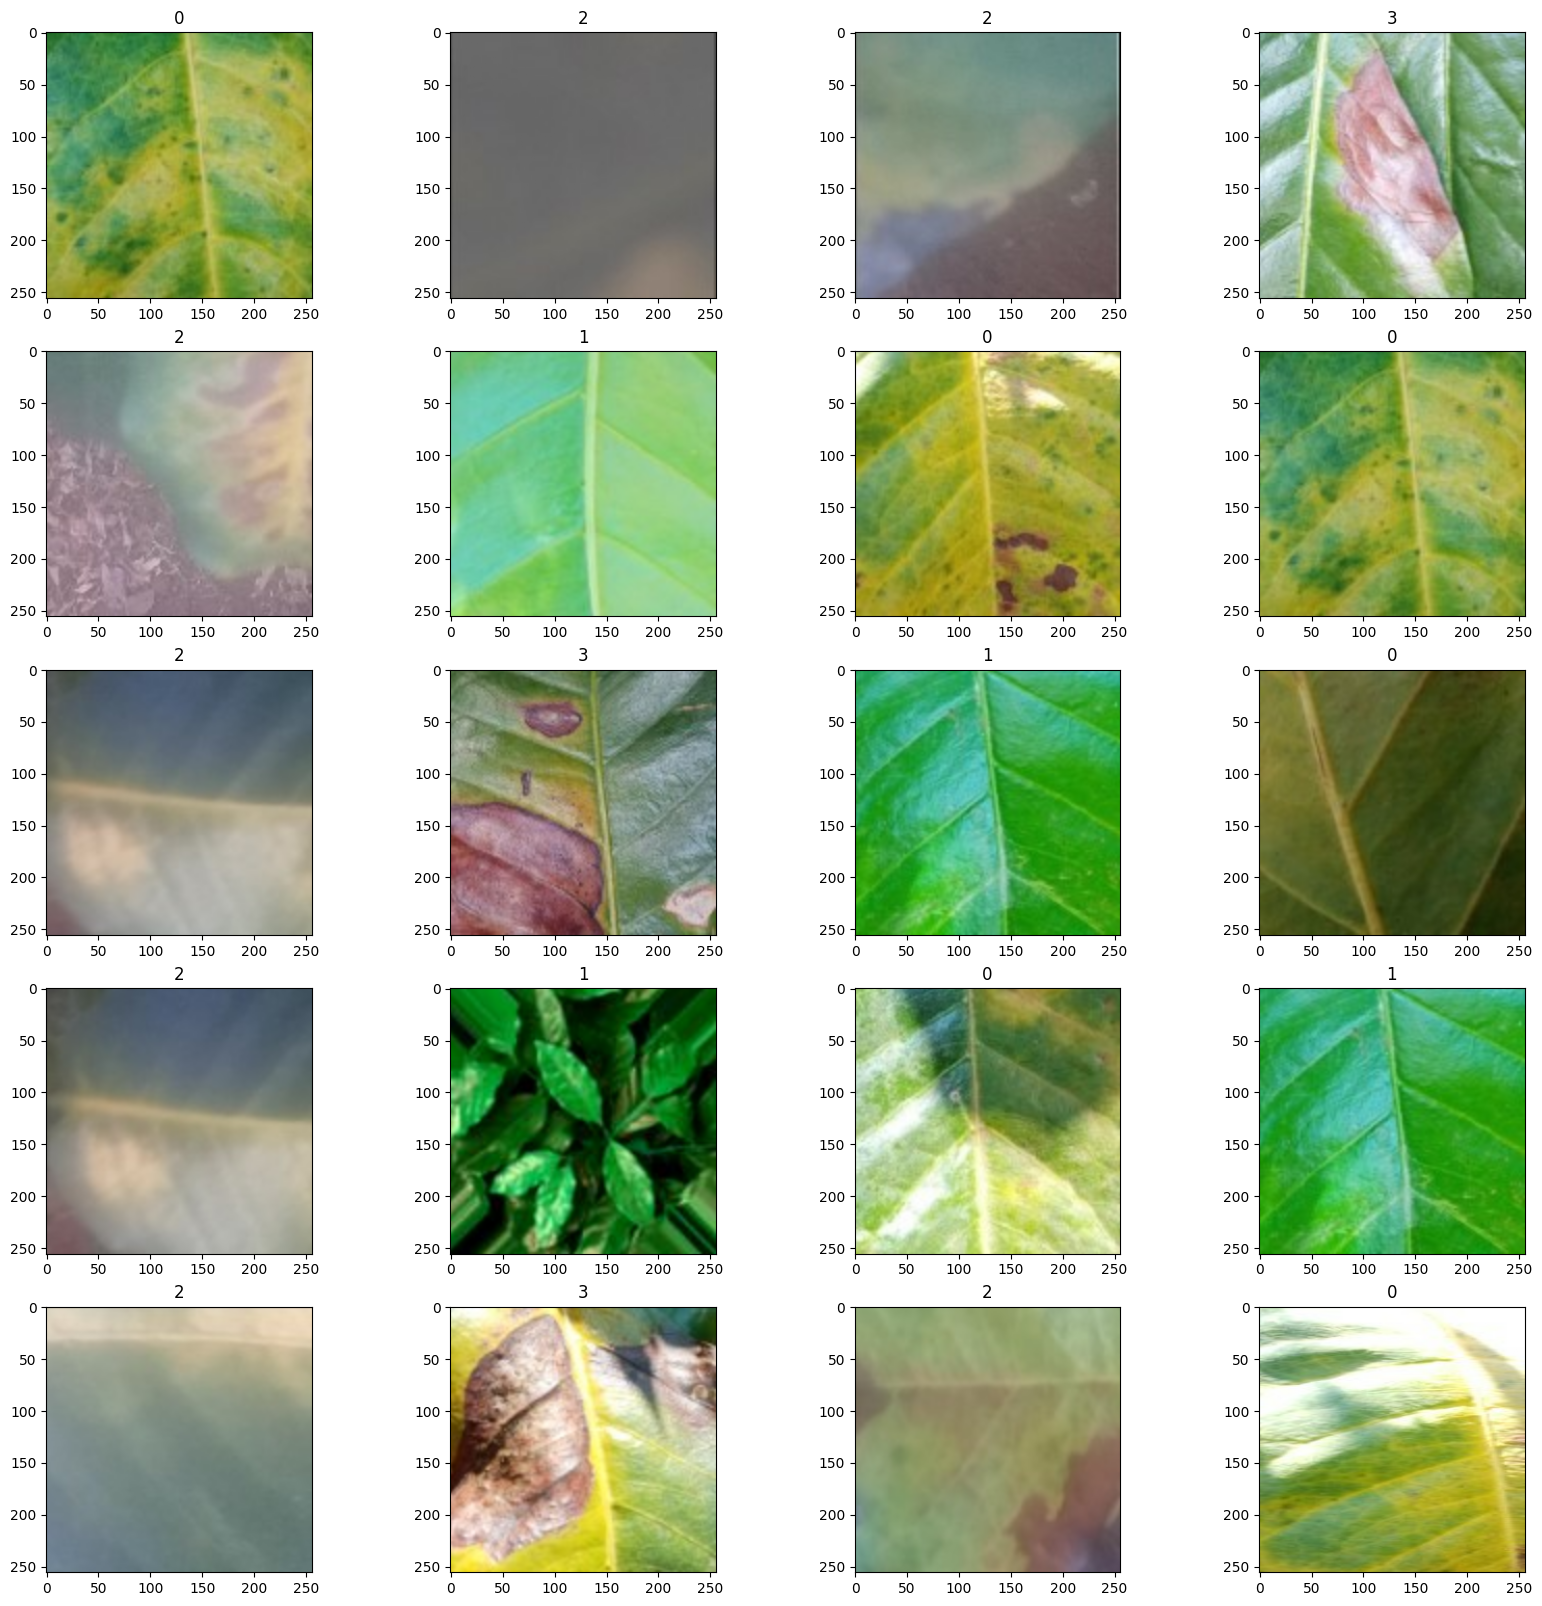

In [ ]:
#  Displaying a grid of images along with their corresponding labels using matplotlib.
# The images are obtained from a batch of scaled images.

fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(20,20))
for i in range(5):
    for j in range(4):
        idx = i * 4 + j
        ax[i, j].imshow(batch_scaled[0][idx])
        ax[i, j].set_title(batch_scaled[1][idx])
plt.show()

From the above, we can see the images with their assigned classes.

We visualize the distribution of each class in the training and test sets.

In [ ]:
# Convert EagerTensor to a NumPy array and then to a Python list
class_distribution = train.reduce(0, lambda x, _: x + 1).numpy().tolist()

# Display class distribution in the training set
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_distribution)
plt.title("Class Distribution in the Training Set")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
# Convert EagerTensor to a NumPy array and then to a Python list
class_distribution_test = test.reduce(0, lambda x, _: x + 1).numpy().tolist()

# Display class distribution in the testing set
plt.figure(figsize=(8, 5))
plt.bar(class_names, class_distribution_test)
plt.title("Class Distribution in the Testing Set")
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.show()

We load the images from the directory and plot five images from each class.

In [ ]:
# Set the main folder path
main_folder_path = "/content/drive/MyDrive/Imageclassification3/Data"

# Initialize an empty list to store the images
images = []

# Iterate over the image classes in the main folder path
for image_class in os.listdir(main_folder_path):
    # Iterate over the images in each image class
    for image in os.listdir(os.path.join(main_folder_path, image_class)):
        # Create the full image path
        image_path = os.path.join(main_folder_path, image_class, image)
        # Read the image using OpenCV
        img = cv2.imread(image_path)
        # Check if the image was loaded successfully
        if img is None:
            continue
        # Append the image to the list
        images.append(img)

In [ ]:
# Create an empty dictionary to store images by class
images_by_class = {class_name: [] for class_name in class_names}

# Iterate through the dataset to collect five images for each class
for images, labels in data:
    for image, label in zip(images, labels):
        # Get the class name of the current image
        class_name = class_names[label.numpy()]
        # Check if the number of images for the current class is less than 5
        if len(images_by_class[class_name]) < 5:
            # Append the image to the list of images for the current class
            images_by_class[class_name].append(image.numpy())

# Plot the selected images
fig, axes = plt.subplots(nrows=len(class_names), ncols=5, figsize=(15, 3 * len(class_names)))

# Iterate through each class
for i, class_name in enumerate(class_names):
    # Iterate through each image for the current class
    for j, image in enumerate(images_by_class[class_name]):
        # Show the image on the corresponding subplot
        axes[i, j].imshow(image.astype(int))
        # Remove the axis labels
        axes[i, j].axis('off')
        # Set the title of the subplot as the class name
        axes[i, j].set_title(class_name)

# Display the plot
plt.show()

The above plot shows five images from each class.

In [ ]:
# Create a dictionary to store image statistics for each class
image_statistics_by_class = {class_name: {'mean': [], 'std': []} for class_name in class_names}

# Iterate through the dataset to calculate image statistics for each class
for images, labels in data:
    for image, label in zip(images, labels):
        # Get the class name for the current label
        class_name = class_names[label.numpy()]
        
        # Convert the image to numpy array
        image_np = image.numpy()
        
        # Calculate the mean and standard deviation values for the image
        mean_values = np.mean(image_np, axis=(0, 1))
        std_values = np.std(image_np, axis=(0, 1))
        
        # Store the calculated statistics in the dictionary
        image_statistics_by_class[class_name]['mean'].append(mean_values)
        image_statistics_by_class[class_name]['std'].append(std_values)

# Display the image statistics for each class
for class_name, statistics in image_statistics_by_class.items():
    # Calculate the mean and standard deviation values for the class
    mean_values = np.mean(statistics['mean'], axis=0)
    std_values = np.mean(statistics['std'], axis=0)
    
    # Print the class name and its corresponding mean and standard deviation values
    print(f"{class_name} - Mean values: {mean_values}, Std values: {std_values}")

**Don't forget to change this**

The above shows image statistics:
- Leafrust - Mean values: [161.60753 159.4717  139.56525]
- Cerscospora - Mean values: [122.892944 135.90146   75.10353 ]
- Phoma - Mean values: [137.64145  145.31415  103.197296]
- Healthy - Mean values: [ 98.33829 188.19473 100.818  ]

The values represent the pixel intesity for each color channel (Red, Green,Blue) in the coffee rust images:

- Cerscospora - Std values: [34.28025  29.135378 34.75246 ]
- Healthy - Std values: [23.072763  11.9626665 34.3454   ]
- Leafrust - Std values: [23.233397 19.865278 17.498693]
- Phoma - Std values: [46.716785 39.924976 44.30034 ]

These values represent the standard deviation of pixel intensities for each color channel. A higher standard deviation implies greater variability in pixel intensities.

From the above, higher mean values suggest brigher images in the corresponding color channel. e.g Coffee Rust images tend to have higher average intensities in the red channel compared to Cerscospora, Phoma and healthy leaf images.

Healthy leaf images tend to have higher average intensities in the green channel compared to Cerscospora, Phoma and leafrust leaf images.

# **Modeling**

### Baseline Model

In [ ]:
# Create a baseline model
baseline_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
baseline_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Fit the model
history_bsm = baseline_model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
121/649 [====>.........................] - ETA: 23:18 - loss: 14.2984 - accuracy: 0.5726

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = baseline_model.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

### II. Model 2

In [ ]:
# Create a deeper model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')
])

# Compile the model
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Train the model on the dataset
history_2 = model_2.fit(train, epochs=5, validation_data=val)


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_2.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

### III. Model 3

In [ ]:
# Define the CNN model
model_3 = models.Sequential()

# Convolutional layers
model_3.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))
model_3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_3.add(layers.MaxPooling2D((2, 2)))

# Flatten layer to transition from convolutional to dense layers
model_3.add(layers.Flatten())

# Dense layers
model_3.add(layers.Dense(128, activation='relu'))
model_3.add(layers.Dense(4, activation='softmax'))

# Compile the model
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model_3.summary()

# Train the model on the dataset
history_2 = model_3.fit(train, epochs=5, validation_data=val)

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_3.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

### IV. Model 4

In [ ]:
# Define the CNN model
model_4 = models.Sequential()

# Convolutional layers
model_4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_4.add(layers.MaxPooling2D((2, 2)))
model_4.add(layers.Conv2D(256, (3, 3), activation='relu'))  # Additional convolutional layer
model_4.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model_4.add(layers.Flatten())

# Dense layers
model_4.add(layers.Dense(256, activation='relu'))  # Increased number of units
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(4, activation='softmax'))

# Compile the model
model_4.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model_4.summary()

# Train the model on the dataset
history_3 = model_4.fit(train, epochs=5, validation_data=val)

In [ ]:
test_loss, test_accuracy = model_4.evaluate(test)
print(f"Test Accuracy: {test_accuracy}")

In [ ]:
# Save the trained models
baseline_model.save('/content/drive/MyDrive/Imageclassification3/Final_Models/baseline_model.h5')
model_2.save('/content/drive/MyDrive/Imageclassification3/Final_Models/model_2.h5')
model_3.save('/content/drive/MyDrive/Imageclassification3/Final_Models/model_3.h5')
model_4.save('/content/drive/MyDrive/Imageclassification3/Final_Models/model_4.h5')

### Image Classification Predictions

Making a prediction using a pre-trained image classification model. 

In [ ]:
def preprocess_image(image_path):
    """ Preprocesses the image by resizing it to 256x256 pixels, 
    scaling the pixel values to be between 0 and 1, 
    and adding a batch dimension to the image. 
    """
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Load the saved model
saved_model_path = '/content/drive/MyDrive/Imageclassification2/Models/model_2.h5'
model = load_model(saved_model_path)

# Preprocess the image
image_path = '/content/Coffee_leaves.jpg'
preprocessed_image = preprocess_image(image_path)

# Make predictions
predictions = model.predict(preprocessed_image)
class_names = data.class_names

# Get the predicted class index
predicted_class_index = np.argmax(predictions)

# Get the predicted class label
predicted_class_label = class_names[predicted_class_index]

# Display the prediction
print(f"Predicted Class: {predicted_class_label}")

# **Conclusion**
We have concluded that the best performing model is... based on.....

# **Recommendation**







# **Next Steps**
**1. Continuous Monitoring and Retraining:**
Establish a system to track model performance in real-world settings continuously. Retrain the model on a regular basis to adapt to changing conditions and evolving disease pattern in real time. model performance in real-world settings continuously.

**2. Education and Awareness Campaigns:**
Start education and awareness programs to provide coffee farmers with information on disease prevention, early detection, and sustainable farming practices,


**3. Long-Term Sustainability Planning:**
Create long-term sustainability plans for the project that address resource allocation, community involvement, and scalability.








In [ ]:
import numpy as np
from tensorflow.keras.models import load_model

def preprocess_image(image):
    # Preprocess the image (resize, normalize, etc.)
    # This function should be tailored to match the preprocessing steps used during training
    return processed_image

def load_models(model_paths):
    models = []
    for path in model_paths:
        model = load_model(path)
        models.append(model)
    return models

def predict_image(models, image):
    # Make predictions using each individual model
    predictions = [np.argmax(model.predict(image), axis=1) for model in models]

    # Combine predictions using voting
    combined_predictions = np.array([np.argmax(np.bincount(pred)) for pred in zip(*predictions)])

    return combined_predictions

def main():
    # Paths to pre-trained model files
    model_paths = ['model1.h5', 'model2.h5', 'model3.h5']

    # Load pre-trained models
    models = load_models(model_paths)

    # Example image to classify (replace with actual image data)
    image = preprocess_image(example_image)

    # Make predictions using the ensemble of models
    predictions = predict_image(models, image)

    # Output the final prediction
    print("Ensemble Prediction:", predictions)

if __name__ == "__main__":
    main()

In [ ]:
history = model.fit()